# **Menon Labs: Trending Youtube Video Statistics Across Different Nations Data Analysis**

## **Colaborators**:
- Ashna Sood
- Mackenzie Chen

## **Imports**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import classification_report, precision_recall_fscore_support, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## **USA youtube data**

### **Data Wrangling**

In [2]:
# mount data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# read in USA Youtube trending data 
US_df = pd.read_csv("/content/drive/MyDrive/youtube_data/USvideos.csv")
US_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
US_df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [5]:
US_df["video_error_or_removed"].value_counts()

False    40926
True        23
Name: video_error_or_removed, dtype: int64

In [6]:
# drop unecessary columns and rename columns
US_df = US_df.drop(columns={"thumbnail_link", "description"})
US_df = US_df.rename(columns={"video_id":"Video ID", "trending_date":"Date", "title": "Title", 
                              "channel_title": "Channel", "category_id": "Category ID", 
                              "publish_time": "Published","tags": "Tags", "views": "Views", "likes": "Likes",
                             "dislikes": "Dislikes", "comment_count": "Num Comments",
                              "comments_disabled": "Comments Disabled", "ratings_disabled": "Ratings Disabled", 
                              "video_error_or_removed": "Error"})
# sort rows in descending order with respect to number of views
US_df = US_df.sort_values(by=['Views'], ascending=False)
US_df = US_df.assign(Country = "US")
# remove Country from the list and add back to beginning of df
cols = list(US_df.columns.values) 
cols.pop(cols.index('Country')) 
US_df = US_df[["Country"] + cols]

US_df.head()

,Country,Video ID,Date,Title,Channel,Category ID,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
38547,US,VYOjWnS4cMY,18.02.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False
38345,US,VYOjWnS4cMY,18.01.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",220490543,4962403,338105,512337,False,False,False
38146,US,VYOjWnS4cMY,18.31.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",217750076,4934188,335462,509799,False,False,False
37935,US,VYOjWnS4cMY,18.30.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",210338856,4836448,326902,501722,False,False,False
37730,US,VYOjWnS4cMY,18.29.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",205643016,4776680,321493,496211,False,False,False


In [7]:
# see the True/False counts
print("Comments Disabled count:\n", US_df["Comments Disabled"].value_counts())
print("Ratings Disabled count:\n", US_df["Ratings Disabled"].value_counts())
print("Error count:\n", US_df["Error"].value_counts())

Comments Disabled count:
 False    40316
True       633
Name: Comments Disabled, dtype: int64
Ratings Disabled count:
 False    40780
True       169
Name: Ratings Disabled, dtype: int64
Error count:
 False    40926
True        23
Name: Error, dtype: int64


In [8]:
# binarize True/False cols to True - 1 and False - 0
US_df["Comments Disabled"] = US_df["Comments Disabled"].astype(int)
US_df["Ratings Disabled"] = US_df["Ratings Disabled"].astype(int)
US_df["Error"] = US_df["Error"].astype(int)

In [9]:
print("Comments Disabled count:\n", US_df["Comments Disabled"].value_counts())
print("Ratings Disabled count:\n", US_df["Ratings Disabled"].value_counts())
print("Error count:\n", US_df["Error"].value_counts())

Comments Disabled count:
 0    40316
1      633
Name: Comments Disabled, dtype: int64
Ratings Disabled count:
 0    40780
1      169
Name: Ratings Disabled, dtype: int64
Error count:
 0    40926
1       23
Name: Error, dtype: int64


In [10]:
US_df

,Country,Video ID,Date,Title,Channel,Category ID,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
38547,US,VYOjWnS4cMY,18.02.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,0,0,0
38345,US,VYOjWnS4cMY,18.01.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",220490543,4962403,338105,512337,0,0,0
38146,US,VYOjWnS4cMY,18.31.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",217750076,4934188,335462,509799,0,0,0
37935,US,VYOjWnS4cMY,18.30.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",210338856,4836448,326902,501722,0,0,0
37730,US,VYOjWnS4cMY,18.29.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",205643016,4776680,321493,496211,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,US,-JVITToppE0,17.16.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,2017-11-13T20:41:45.000Z,"Oregon|""Ducks""|""college athletics""|""college fo...",687,10,2,5,0,0,0
14531,US,dQMZLXaa1L8,18.27.01,Artwork Forge,Palo Alto Online,17,2018-01-10T23:53:56.000Z,[none],658,1,0,0,0,0,0
14782,US,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",559,9,0,4,0,0,0
14563,US,y6KYFcta4SE,18.27.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",554,9,0,4,0,0,0


### **EDA**

In [11]:
# Check for null values
print("Missing Values?", US_df.isna().values.any())

Missing Values? False


In order to understand the types of trending YouTube videos in a particular region, it is vital to understand what the possible categories of trending videos are. Each CSV file with the top trending videos from each nation are all labeled with a Category ID, and these ID's are identical across all CSV files. Thus, we will now parce through the US json file to get all the categories and their respective IDs. However, it is important to note that not all types of videos will be present in each country's csv file, as certain types of videos were more popular and trending in that specific region.

In [12]:
# get list of all the possible categories of videos 
categories_js = pd.read_json("/content/drive/MyDrive/youtube_data/US_category_id.json", orient="columns")
ids = []
categories = []
for ind in range(len(categories_js)):
    col = categories_js["items"][ind]
    id = int(col["id"])
    ids.append(id)
    title = col["snippet"]["title"]
    categories.append(title)

final_categories = dict(zip(ids, categories))  
final_categories

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [13]:
# create df with all of the categories and its respective category ID
categories_df = pd.DataFrame.from_dict(final_categories, orient="index")
categories_df = categories_df.rename(columns={0: "Category"})
categories_df.head()

,Category
1,Film & Animation
2,Autos & Vehicles
10,Music
15,Pets & Animals
17,Sports


In [14]:
# add respective category to each row based on its category ID
US_df = US_df.merge(categories_df, how= "left", left_on= "Category ID", right_index = True)
US_df

,Country,Video ID,Date,Title,Channel,Category ID,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error,Category
38547,US,VYOjWnS4cMY,18.02.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,0,0,0,Music
38345,US,VYOjWnS4cMY,18.01.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",220490543,4962403,338105,512337,0,0,0,Music
38146,US,VYOjWnS4cMY,18.31.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",217750076,4934188,335462,509799,0,0,0,Music
37935,US,VYOjWnS4cMY,18.30.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",210338856,4836448,326902,501722,0,0,0,Music
37730,US,VYOjWnS4cMY,18.29.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",205643016,4776680,321493,496211,0,0,0,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,US,-JVITToppE0,17.16.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,2017-11-13T20:41:45.000Z,"Oregon|""Ducks""|""college athletics""|""college fo...",687,10,2,5,0,0,0,Sports
14531,US,dQMZLXaa1L8,18.27.01,Artwork Forge,Palo Alto Online,17,2018-01-10T23:53:56.000Z,[none],658,1,0,0,0,0,0,Sports
14782,US,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",559,9,0,4,0,0,0,News & Politics
14563,US,y6KYFcta4SE,18.27.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",554,9,0,4,0,0,0,News & Politics


In [15]:
# remove Country from the list and add it after Category ID
category_data = US_df["Category"]
category_data
US_df = US_df.drop(labels=["Category"], axis=1)
US_df.insert(6, "Category", category_data)
US_df

,Country,Video ID,Date,Title,Channel,Category ID,Category,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
38547,US,VYOjWnS4cMY,18.02.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,Music,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,0,0,0
38345,US,VYOjWnS4cMY,18.01.06,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,Music,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",220490543,4962403,338105,512337,0,0,0
38146,US,VYOjWnS4cMY,18.31.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,Music,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",217750076,4934188,335462,509799,0,0,0
37935,US,VYOjWnS4cMY,18.30.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,Music,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",210338856,4836448,326902,501722,0,0,0
37730,US,VYOjWnS4cMY,18.29.05,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,Music,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",205643016,4776680,321493,496211,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,US,-JVITToppE0,17.16.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,Sports,2017-11-13T20:41:45.000Z,"Oregon|""Ducks""|""college athletics""|""college fo...",687,10,2,5,0,0,0
14531,US,dQMZLXaa1L8,18.27.01,Artwork Forge,Palo Alto Online,17,Sports,2018-01-10T23:53:56.000Z,[none],658,1,0,0,0,0,0
14782,US,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,News & Politics,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",559,9,0,4,0,0,0
14563,US,y6KYFcta4SE,18.27.01,"1 dead, others injured after Ky. school shooting",Newsy,25,News & Politics,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",554,9,0,4,0,0,0


In [16]:
print("Category ID count:\n", US_df["Category ID"].value_counts())

Category ID count:
 24    9964
10    6472
26    4146
23    3457
22    3210
25    2487
28    2401
1     2345
17    2174
27    1656
15     920
20     817
19     402
2      384
29      57
43      57
Name: Category ID, dtype: int64


From the Category ID distribution, we can see that category 24, which is Entertainment, contains the highest amount of trending videos. This is quite understandable as one of the main primary uses and popular types of videos on Youtube are Entertainment based. The second most popular category is category 10, which is Music. This is also quite understandable as musicians post their music videos on Youtube and those usually gain the most amount of views, and usually trend for a period of time after the initial release. Lastly, the third most popular category is category 26, Howto & Style, which is also a main use for almost all generations -- looking up tutorials. The least popular video category with the fewest trending videos is category 43, which is shows. This is a bit surprising as  sometimes the trailers for new episodes on shows are featured, but also makes sense as full episodes of shows are usually never fully available on YouTube, and are present on other apps like Netflix, Disney+, HBOMax, etc. 

In [17]:
print("Channel counts:\n", US_df["Channel"].value_counts())

Channel counts:
 ESPN                                       203
The Tonight Show Starring Jimmy Fallon     197
Netflix                                    193
Vox                                        193
TheEllenShow                               193
                                          ... 
Tamar Chronicles                             1
Movieclips Film Festivals & Indie Films      1
TrainVEVO                                    1
KSNV News 3 Las Vegas                        1
LetsGoWarriors                               1
Name: Channel, Length: 2207, dtype: int64


From the Channel distribution, it is evident that the channel with the most amount of trending vidoes is ESPN, which is a form of entertainment, as that channel highlights the main sporting events. Sports is a crucial form of entertainment in most US households, so it makes sense that it is one of the most trending channels. It is important to note that the top 5 categories all have a frequency in the 190s, and these categories are Jimmy Falon's tonight show, one of the most popular entertainment late night shows, Vox, Netflix, and TheEllenShow, one of the most popoular daytime entertainment talk shows. 

In [18]:
# general statistics about the data distribution
US_df.describe()

,Category ID,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04,40949.000000,40949.000000,40949.000000
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03,0.015458,0.004127,0.000562
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04,0.123368,0.064110,0.023693
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02,0.000000,0.000000,0.000000
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03,0.000000,0.000000,0.000000
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03,0.000000,0.000000,0.000000
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,1.000000,1.000000,1.000000


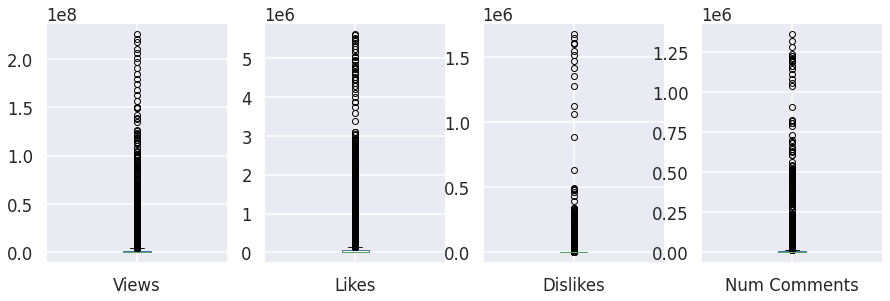

In [19]:
cont_features = ["Views", "Likes", "Dislikes",  "Num Comments"]
# univariate analysis for continuous features to visualize the distributions of the variables  
US_df[cont_features].plot(kind='box', figsize=(15, 15), subplots=True, layout=(3, 4))
plt.show()

In [20]:
# correlations between the main continuous varibles
US_corrs = US_df.corr()
US_corrs

,Category ID,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
Category ID,1.000000,-0.168231,-0.173921,-0.033547,-0.076307,0.048949,-0.013506,-0.030011
Views,-0.168231,1.000000,0.849177,0.472213,0.617621,0.002677,0.015355,-0.002256
Likes,-0.173921,0.849177,1.000000,0.447186,0.803057,-0.028918,-0.020888,-0.002641
Dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184,-0.004431,-0.008230,-0.001853
Num Comments,-0.076307,0.617621,0.803057,0.700184,1.000000,-0.028277,-0.013819,-0.003725
Comments Disabled,0.048949,0.002677,-0.028918,-0.004431,-0.028277,1.000000,0.319230,-0.002970
Ratings Disabled,-0.013506,0.015355,-0.020888,-0.008230,-0.013819,0.319230,1.000000,-0.001526
Error,-0.030011,-0.002256,-0.002641,-0.001853,-0.003725,-0.002970,-0.001526,1.000000


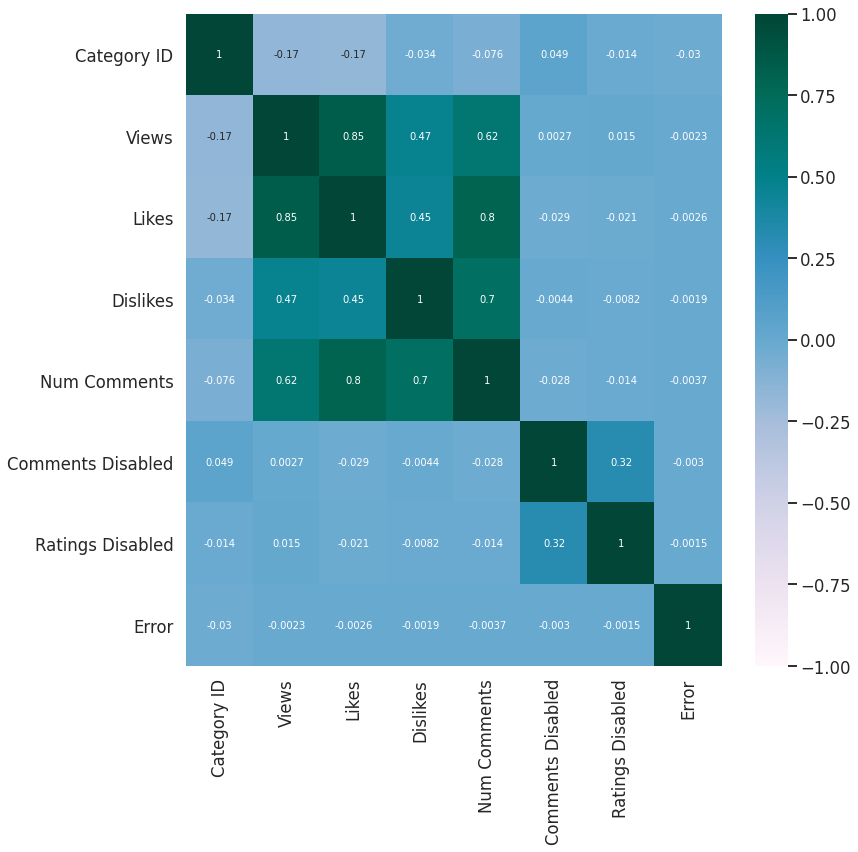

In [21]:
# visualize correlation matrix in a heatmap to easily depict the highly correlated variables
plt.figure(figsize=(12, 12))
sns.heatmap(US_corrs, annot=True, vmin=-1.0, cmap='PuBuGn')
plt.show()

Based on the heatmap of the correlation matrix, it is evident that there is a strong correlation of 0.85 between the number of likes and number of views, which intuitively makes sense as more liked videos will have more views. Similarly, there is also a strong correlation of 0.8 between the number of likes and number of comments as both are correlated in terms of if people like a certain video, they are more likely to comment their reaction as well. The next strongest correlation of 0.70 is between the number of dislikes and the number of comments, as people regardless of their like or dislike towards the video will express their opinions in the comments, so if they are not a fan of the video they will still most likely comment. There is a weaker correlation between the number of dislikes and the number of views, understandably as a more disliked and unpleasant video won't have as many views as one that is more pleasing to viewers.

### **Performing Multivariate Linear Regression -- predicting Number of Views**

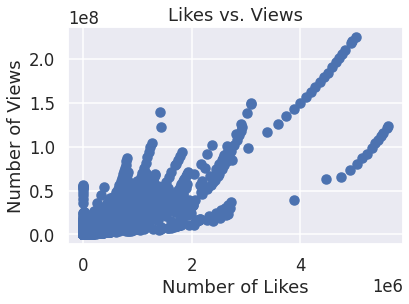

In [22]:
# number of likes vs number of views
plt.scatter(US_df["Likes"], US_df["Views"])
plt.xlabel("Number of Likes")
plt.ylabel("Number of Views")
plt.title("Likes vs. Views")
plt.show()

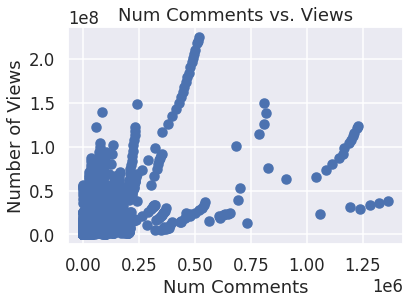

In [23]:
# Num Comments vs number of views
plt.scatter(US_df["Num Comments"], US_df["Views"])
plt.xlabel("Num Comments")
plt.ylabel("Number of Views")
plt.title("Num Comments vs. Views")
plt.show()

For Model 1 we decided to use the top attribute we found being most correlated to the number of views from our correlation matrix -- the number of likes.

In [24]:
# model 1 with the strongest correlating variable to views -- # Likes 
# num likes predicting views
X = US_df[["Likes"]]
y = US_df["Views"]

In [25]:
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m1_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m1_regressor.predict(X_test)

# results of model 1 actual vs predicteds 
result1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result1.head(3)

,Actual,Predicted
36632,1217496,2.982076e+06
16682,46653,3.208438e+05
19230,275259,6.275131e+05


In [26]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m1_weights = np.round(m1_regressor.coef_, 4)
m1_intercept = np.round(m1_regressor.intercept_, 4)

print("Y = ", m1_weights[0], "* Likes +", m1_intercept)

Y =  27.5262 * Likes + 313989.8126


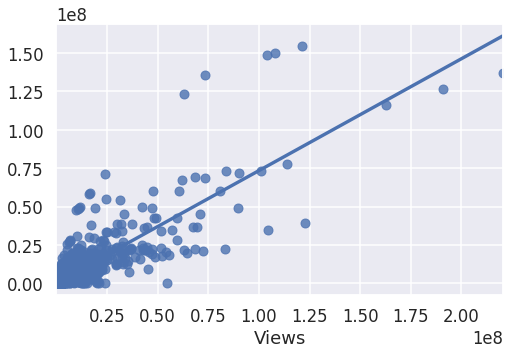

In [27]:
# plot the actual values vs the predicted values for model 1 
plt.figure(figsize=(8,5))
ax = sns.regplot(x=y_test, y=y_pred, ci=None, color="b")

In [28]:
# calculate regressor metrics MSE and RMSE for model 1
m1_mae = mean_absolute_error(y_test, y_pred)
m1_mse = mean_squared_error(y_test, y_pred)
m1_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 1 MAE:", m1_mae)
print("Model 1 MSE:", m1_mse)
print("Model 1 RMSE:", m1_rmse)

Model 1 MAE: 1239504.991589524
Model 1 MSE: 15800304157333.99
Model 1 RMSE: 3974959.642227074


For Model 2 we decided to use the top two attributes we found being most positively and negatively correlated to the number of views from our correlation matrix. The two attributes most correlated with the number of views are the number of likes and the number of comments.

In [29]:
# model 2 with the top two most correlating variables 
# num likes and num comments predicting views
X = US_df[["Likes", "Num Comments"]]
y = US_df["Views"]

In [30]:
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m2_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m2_regressor.predict(X_test)

# results of model 2 actual vs predicteds 
result2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result2.head()

,Actual,Predicted
5974,92178,2.471695e+05
11620,4058571,1.130975e+07
40852,1237208,9.039145e+05
8203,1446516,1.787398e+06
12735,344669,5.426230e+05


In [31]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m2_weights = np.round(m2_regressor.coef_, 4)
m2_intercept = np.round(m2_regressor.intercept_, 4)

m2_weights
print("Y = ", m2_weights[0], "* Likes +", m2_weights[1], "* Num Comments +", m2_intercept)

Y =  33.7386 * Likes + -47.0347 * Num Comments + 249964.6429


In [32]:
# calculate regressor metrics MSE and RMSE for model 2
m2_mae = mean_absolute_error(y_test, y_pred)
m2_mse = mean_squared_error(y_test, y_pred)
m2_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 2 MAE:", m2_mae)
print("Model 2 MSE:", m2_mse)
print("Model 2 RMSE:", m2_rmse)

Model 2 MAE: 1242038.4632123664
Model 2 MSE: 14048313577092.633
Model 2 RMSE: 3748107.999656978


For model 3, we decided to combine the top three most correlated variables with the number of views, and see how all three together predict the number of views.

In [33]:
# model 3 combining num likes, dislikes, and num comments to predict views
# model 3 with the top three most correlating variables 
# num likes and num comments predicting views
X = US_df[["Likes", "Dislikes", "Num Comments"]]
y = US_df["Views"]

In [34]:
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m3_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m3_regressor.predict(X_test)

# results of model 2 actual vs predicteds 
result3 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result3.head()

,Actual,Predicted
1272,720203,9.551324e+05
18525,1455355,7.255208e+05
24311,2445835,1.898161e+06
12313,3333,2.203257e+05
3510,1266148,1.681769e+06


In [35]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m3_weights = np.round(m3_regressor.coef_, 4)
m3_intercept = np.round(m3_regressor.intercept_, 4)

print("Y = ", m2_weights[0], "* Likes +", m3_weights[1], "* Dislikes + ", m3_weights[2], "* Num Comments +", m3_intercept)

Y =  33.7386 * Likes + 82.742 * Dislikes +  -100.2195 * Num Comments + 220434.1009


In [36]:
# calculate regressor metrics MSE and RMSE for model 2
m3_mae = mean_absolute_error(y_test, y_pred)
m3_mse = mean_squared_error(y_test, y_pred)
m3_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 3 MAE:", m3_mae)
print("Model 3 MSE:", m3_mse)
print("Model 3 RMSE:", m3_rmse)

Model 3 MAE: 1227099.1061006745
Model 3 MSE: 11791907654651.506
Model 3 RMSE: 3433934.7190433755


#### **Model Comparison**

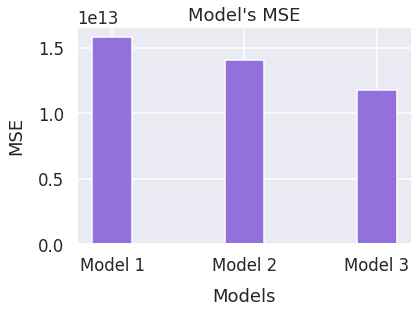

In [37]:
# plot and visually compare the MSE's for each model
MSE = np.round([m1_mse, m2_mse, m3_mse], 4)
labels = ["Model 1", "Model 2", "Model 3"]
plt.bar(labels, MSE, color="mediumpurple", width = 0.3)
plt.xlabel("Models", labelpad=13)
plt.ylabel("MSE", labelpad=13)
plt.title("Model's MSE")

plt.show()

Since the scale of the MSE metric is disproportionate to the MAE and RMSE metrics, we further plotted the MAE and RMSE metrics to visualize the differences between those two metrics. 

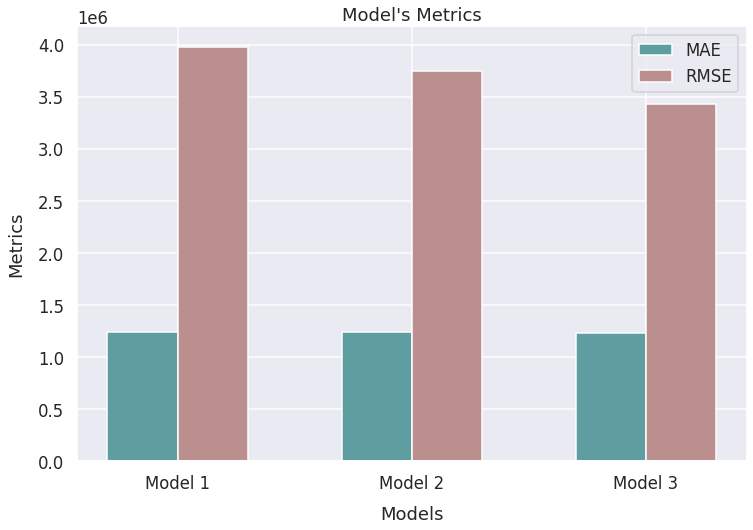

In [38]:
# plot and visually compare the MAE and RMSE metrics for each model
plt.figure(figsize=(12, 8))
MAE = np.round([m1_mae, m2_mae, m3_mae], 4)
RMSE = np.round([m1_rmse, m2_rmse, m3_rmse], 4)
labels = ["Model 1", "Model 2", "Model 3"]
ind = np.arange(3)
width = 0.3
plt.bar(ind, MAE, width, label = "MAE", color="cadetblue")
plt.bar(ind + width, RMSE, width, label = "RMSE", color="rosybrown")

plt.xlabel("Models", labelpad=13)
plt.ylabel("Metrics", labelpad=13)
plt.xticks(ind + width/2, (labels))
plt.xticks(ha= "center")
plt.title("Model's Metrics")
plt.legend(loc="upper right")

plt.show()

Overall, we can see that model 3 better predicts the number of views, so all three attributes - the number of likes, dislikes, and number of comments on a video all strongly correlate with the number of views and are an important factor in determing which videos trend.

### **Performing Linear Regression -- predicting Number of Comments with Likes and Dislikes**

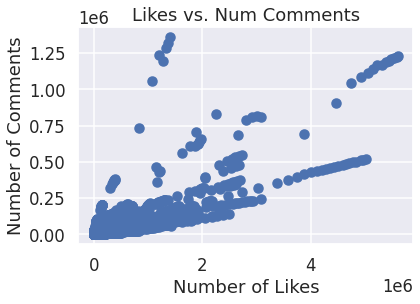

In [39]:
# num likes vs num comments
plt.scatter(US_df["Likes"], US_df["Num Comments"])
plt.xlabel("Number of Likes")
plt.ylabel("Number of Comments")
plt.title("Likes vs. Num Comments")
plt.show()

It is evident that there is a strong correlation between the number of likes and the number of views, and similarly we would like to further explore if the number of likes can predict the number of comments. 

In [40]:
# model 4 with the top correlating variable 
# num likes predicting num comments
X = US_df[["Likes"]]
y = US_df["Num Comments"]

In [41]:
# model 4 num likes, dislikes, and num comments predicting views
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m4_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m4_regressor.predict(X_test)

# results of model 2 actual vs predicteds 
result4 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result4.head()

,Actual,Predicted
31784,1001,-368.355087
17519,39,-1327.665318
26438,1462,4182.791126
34201,0,-971.922227
2429,1998,1116.842078


In [42]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m4_weights = np.round(m4_regressor.coef_, 4)
m4_intercept = np.round(m4_regressor.intercept_, 4)

print("Y = ", m4_weights[0], "* Likes +", m4_intercept)

Y =  0.1344 * Likes + -1436.1219


In [43]:
# calculate regressor metrics MSE and RMSE for model 3
m4_mae = mean_absolute_error(y_test, y_pred)
m4_mse = mean_squared_error(y_test, y_pred)
m4_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 4 MAE:", m4_mae)
print("Model 4 MSE:", m4_mse)
print("Model 4 RMSE:", m4_rmse)

Model 4 MAE: 5549.65470709143
Model 4 MSE: 428864271.799468
Model 4 RMSE: 20709.038408372995


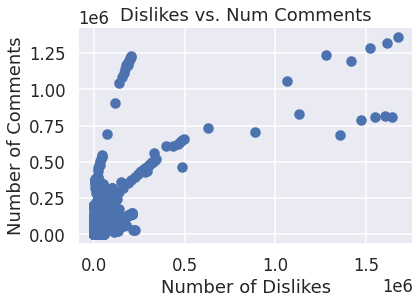

In [44]:
# num dislikes vs num comments
plt.scatter(US_df["Dislikes"], US_df["Num Comments"])
plt.xlabel("Number of Dislikes")
plt.ylabel("Number of Comments")
plt.title("Dislikes vs. Num Comments")
plt.show()

Even though there is a weaker correlation between the number of dislikes and the number of views, we wanted to see if there is a strong correlation between the number of dislikes and the number of comments because people usually express their opinions, both good and bad, in the comments. Thus, the correlation could be high.

In [45]:
# model 5 with the second most correlating variable
# num dislikes predicting num comments
X = US_df[["Dislikes"]]
y = US_df["Num Comments"]

In [46]:
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m5_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m5_regressor.predict(X_test)

# results of model 2 actual vs predicteds 
result5 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result5.head()

,Actual,Predicted
28786,9649,33373.364279
16020,1366,7651.576034
29292,15097,8052.430161
20037,1660,5215.252724
14540,571,5199.180742


In [47]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m5_weights = np.round(m5_regressor.coef_, 4)
m5_intercept = np.round(m5_regressor.intercept_, 4)

print("Y = ", m5_weights[0], "* Dislikes +", m5_intercept)

Y =  0.9454 * Dislikes + 4942.029


In [48]:
# calculate regressor metrics MSE and RMSE for model 4
m5_mae = mean_absolute_error(y_test, y_pred)
m5_mse = mean_squared_error(y_test, y_pred)
m5_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 5 MAE:", m5_mae)
print("Model 5 MSE:", m5_mse)
print("Model 5 RMSE:", m5_rmse)

Model 5 MAE: 7378.041292847693
Model 5 MSE: 852281824.7818898
Model 5 RMSE: 29193.866218469415


Lastly, we wanted to see if the two strongest correlating variables (likes and dislikes) with the number of comments best predicts the number of comments. 

In [49]:
# model 6 with the top two correlating variable
# num likes and num dislikes predicting num comments
X = US_df[["Likes", "Dislikes"]]
y = US_df["Num Comments"]

In [50]:
# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create and train the linear regression model
m6_regressor = LinearRegression().fit(X_train, y_train)

# make predictions
y_pred = m6_regressor.predict(X_test)

# results of model 2 actual vs predicteds 
result6 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result6.head()

,Actual,Predicted
21398,2827,3574.159971
7585,576,421.306900
32684,638,695.887106
23913,1859,1434.215290
20825,991,186.798154


In [51]:
# calculate the weights and y-intercept of the linear regression model and display the equation
m6_weights = np.round(m6_regressor.coef_, 4)
m6_intercept = np.round(m6_regressor.intercept_, 4)

print("Y = ", m6_weights[0], "* Likes +", m6_weights[1], "* Dislikes +", m6_intercept)

Y =  0.1019 * Likes + 0.548 * Dislikes + -1136.1473


In [52]:
# calculate regressor metrics MSE and RMSE for model 4
m6_mae = mean_absolute_error(y_test, y_pred)
m6_mse = mean_squared_error(y_test, y_pred)
m6_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model 6 MAE:", m6_mae)
print("Model 6 MSE:", m6_mse)
print("Model 6 RMSE:", m6_rmse)

Model 6 MAE: 4522.771479588506
Model 6 MSE: 250966239.16934308
Model 6 RMSE: 15841.913999556464


#### **Model Comparison**

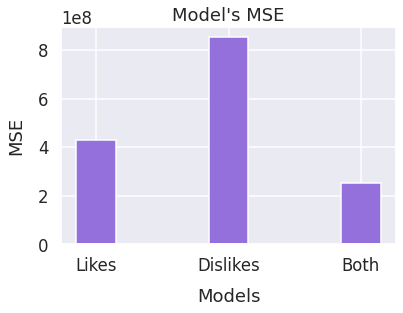

In [53]:
# plot and visually compare the MSE's for each model
MSE = np.round([m4_mse, m5_mse, m6_mse], 4)
labels = ["Likes", "Dislikes", "Both"]
plt.bar(labels, MSE, color="mediumpurple", width = 0.3)
plt.xlabel("Models", labelpad=13)
plt.ylabel("MSE", labelpad=13)
plt.title("Model's MSE")

plt.show()

Since the scale of the MSE metric is disproportionate to the MAE and RMSE metrics, we further plotted the MAE and RMSE metrics to visualize the differences between those two metrics. 

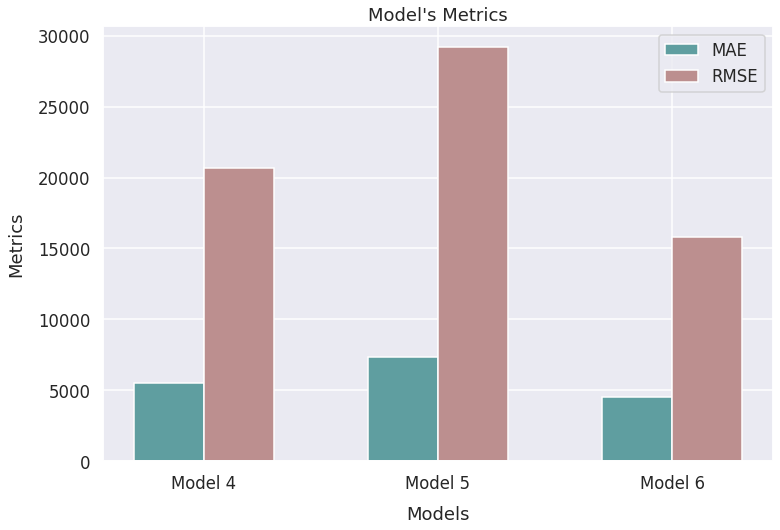

In [54]:
# plot and visually compare the MAE and RMSE metrics for each model
plt.figure(figsize=(12, 8))
MAE = np.round([m4_mae, m5_mae, m6_mae], 4)
RMSE = np.round([m4_rmse, m5_rmse, m6_rmse], 4)
labels = ["Model 4", "Model 5", "Model 6"]
ind = np.arange(3)
width = 0.3
plt.bar(ind, MAE, width, label = "MAE", color="cadetblue")
plt.bar(ind + width, RMSE, width, label = "RMSE", color="rosybrown")


plt.xlabel("Models", labelpad=13)
plt.ylabel("Metrics", labelpad=13)
plt.xticks(ind + width/2, (labels))
plt.xticks(ha= "center")
plt.title("Model's Metrics")
plt.legend(loc="upper right")

plt.show()

Based on the errors, we can see that model 6 performed the best to predict the number of comments, indicating that combining both attributes creates a better model. Individually, the number of likes is a stronger predictor for the number of comments, as the error for the model using dislikes is slightly higher. 

In [55]:
# also use category ID to predict which category has the most views 

## **Combining all the Countries into one DataFrame**

Even though this notebook primarily focuses on analyzing the USA Youtube trending videos and the correlations between the predictor variables, we want to briefly explore the correlations across all countries.

### **Data Wrangling**

In [56]:
# load in the different countries dataframes
GB_df = pd.read_csv("/content/drive/MyDrive/youtube_data/GBvideos.csv")
DE_df = pd.read_csv("/content/drive/MyDrive/youtube_data/DEvideos.csv")
CA_df = pd.read_csv("/content/drive/MyDrive/youtube_data/CAvideos.csv")
FR_df = pd.read_csv("/content/drive/MyDrive/youtube_data/FRvideos.csv")
RU_df = pd.read_csv("/content/drive/MyDrive/youtube_data/RUvideos.csv", encoding="latin-1")
MX_df = pd.read_csv("/content/drive/MyDrive/youtube_data/MXvideos.csv", encoding="latin-1")
KR_df = pd.read_csv("/content/drive/MyDrive/youtube_data/KRvideos.csv", encoding="latin-1")
JP_df = pd.read_csv("/content/drive/MyDrive/youtube_data/JPvideos.csv", encoding="latin-1")
IN_df = pd.read_csv("/content/drive/MyDrive/youtube_data/INvideos.csv")


df_names = [GB_df, DE_df, CA_df, FR_df, MX_df, KR_df, JP_df, IN_df]
countries = ["GB", "DE", "CA", "FR", "MX", "KR", "JP", "IN"]
dfs = []

for df, country in zip(df_names, countries):
    df = df.drop(columns={"thumbnail_link", "description"})
    # binarize True/False cols to True - 1 and False - 0
    df["comments_disabled"] = df["comments_disabled"].astype(int)
    df["ratings_disabled"] = df["ratings_disabled"].astype(int)
    df["video_error_or_removed"] = df["video_error_or_removed"].astype(int)
    df = df.assign(Country = country)
    df = df.sort_values(by=['views'], ascending=False)
    # rename columns 
    df = df.rename(columns={"video_id":"Video ID", "trending_date":"Date", "title": "Title", 
                                "channel_title": "Channel", "category_id": "Category ID", 
                                "publish_time": "Published","tags": "Tags", "views": "Views", "likes": "Likes",
                              "dislikes": "Dislikes", "comment_count": "Num Comments",
                                "comments_disabled": "Comments Disabled", "ratings_disabled": "Ratings Disabled", 
                                "video_error_or_removed": "Error"})
    # remove Country from the list and add back to beginning of df
    cols = list(df.columns.values) 
    cols.pop(cols.index('Country')) 
    df = df[["Country"] + cols]

    # add the Category column for each type of video (corresponding to Category ID)
    df = df.merge(categories_df, how= "left", left_on= "Category ID", right_index = True)
    # remove Country from the list and add it after Category ID
    category_data = df["Category"]
    df = df.drop(labels=["Category"], axis=1)
    df.insert(6, "Category", category_data)
    # add to array
    dfs.append(df)

# combine all country dfs into one
Countries_df = pd.concat(dfs)
Countries_df

,Country,Video ID,Date,Title,Channel,Category ID,Category,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
28412,GB,_I_D_8Z4sJE,18.07.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",424538912,2818771,149275,99380,0,0,0
28212,GB,_I_D_8Z4sJE,18.06.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",413586699,2768654,145643,97218,0,0,0
28008,GB,_I_D_8Z4sJE,18.05.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",402650804,2719005,142006,95713,0,0,0
27811,GB,_I_D_8Z4sJE,18.04.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",392036878,2670723,138334,93834,0,0,0
27615,GB,_I_D_8Z4sJE,18.03.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",382401497,2618320,134625,92387,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,IN,p3Wn9FuI2zo,17.11.12,Dilip Ghosh and Firhad Hakim's political fight...,24 ghanta,24,Entertainment,2017-12-10T14:21:49.000Z,"Zee 24 ghanta|""bangla news""|""zee bangla news""|...",5098,37,5,10,0,0,0
18320,IN,#NAME?,18.22.02,Madhuban Murli LIVE - 22/2/2018 (Thursday 7.00...,Madhuban Murli Brahma Kumaris,27,Education,2018-02-22T02:44:05.000Z,"Daily Murli|""Brahma Kumaris""|""Madhuban""|""Omsha...",4641,185,15,5,0,0,0
20323,IN,18OSLOq-bFA,18.06.03,Madhuban Murli LIVE - 6/3/2018 (Tuesday 7.00am...,Madhuban Murli Brahma Kumaris,27,Education,2018-03-06T02:41:50.000Z,"Daily Murli|""Brahma Kumaris""|""Madhuban""|""Omsha...",4359,191,18,9,0,0,0
29317,IN,iW5ZRboFCMU,18.01.05,रट लो//1 मई 2018 Current Affairs PDF and Quiz...,Golden Era Education,27,Education,2018-05-01T02:15:08.000Z,[none],4287,312,12,100,0,0,0


In [57]:
# lastly, concatenate Countries_df with USA df
contrs_df = [Countries_df, US_df]
Countries_df = pd.concat(contrs_df)
countries.append("US")
dfs.append(US_df)
Countries_df

,Country,Video ID,Date,Title,Channel,Category ID,Category,Published,Tags,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
28412,GB,_I_D_8Z4sJE,18.07.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",424538912,2818771,149275,99380,0,0,0
28212,GB,_I_D_8Z4sJE,18.06.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",413586699,2768654,145643,97218,0,0,0
28008,GB,_I_D_8Z4sJE,18.05.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",402650804,2719005,142006,95713,0,0,0
27811,GB,_I_D_8Z4sJE,18.04.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",392036878,2670723,138334,93834,0,0,0
27615,GB,_I_D_8Z4sJE,18.03.04,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,NickyJamTV,10,Music,2018-03-02T05:00:19.000Z,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Oz...",382401497,2618320,134625,92387,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,US,-JVITToppE0,17.16.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,Sports,2017-11-13T20:41:45.000Z,"Oregon|""Ducks""|""college athletics""|""college fo...",687,10,2,5,0,0,0
14531,US,dQMZLXaa1L8,18.27.01,Artwork Forge,Palo Alto Online,17,Sports,2018-01-10T23:53:56.000Z,[none],658,1,0,0,0,0,0
14782,US,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,News & Politics,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",559,9,0,4,0,0,0
14563,US,y6KYFcta4SE,18.27.01,"1 dead, others injured after Ky. school shooting",Newsy,25,News & Politics,2018-01-23T15:30:01.000Z,"shooting|""kentucky""|""breaking news""|""u.s. news...",554,9,0,4,0,0,0


### **EDA**

In [58]:
# Check for null values
print("Missing Values?", Countries_df.isna().values.any())

Missing Values? False


In [59]:
# A reminder of all the catgories
final_categories

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [60]:
print("Category ID count:\n", Countries_df["Category ID"].value_counts())

Category ID count:
 24    103063
22     43702
10     40619
25     31886
23     23905
17     21716
1      17891
26     16856
20     10455
27      7074
28      7038
15      4259
2       3151
19      1514
29      1254
43       780
30        35
44         5
Name: Category ID, dtype: int64


From the Category ID distribution, we can see that category 24, which is Entertainment, again contains the highest amount of trending videos, meaning that across all the nations, entertainment is still mainly valued and most popular. This is quite understandable as one of the main primary uses and popular types of videos on Youtube are Entertainment based. The second most popular category is category 22, which is People & Blogs. This is new compared to the US statistics where the second most popular category was Music, but also understandable as poeple in all generations across all the nations value content creators and personal opinions. Lastly, the third most popular category is category 10, music, which is a universal popular theme. Music and entertainment ignite and fuel almost all nations, and people rely on music as stress relief and to liven the mood. The least popular video category with the fewest trending videos is category 44, which is Trailers. This is a bit surprising as  sometimes the trailers for new movies or episodes on shows are featured, but also makes sense as full movies are usually never fully available on YouTube, and are present on other apps like Netflix, Disney+, HBOMax, etc. Additionally, compared to the other categories, trailers is a smaller subset of entertainment, which contains more things pertaining to movies and celebrities.

In [61]:
# which category of video has the most views in each country 
top_category_id_in_every_country_by_views = []
for country, df in zip(countries, dfs):
    curr = df.groupby('Category').sum().sort_values('Views', ascending = False).index.to_numpy()[0]
    top_category_id_in_every_country_by_views  = np.append(top_category_id_in_every_country_by_views , {country : curr})
top_category_id_in_every_country_by_views

array([{'GB': 'Music'}, {'DE': 'Entertainment'}, {'CA': 'Entertainment'},
       {'FR': 'Music'}, {'MX': 'Music'}, {'KR': 'Entertainment'},
       {'JP': 'Entertainment'}, {'IN': 'Entertainment'}, {'US': 'Music'}],
      dtype=object)

The code above displays for each country, which category had the most amount of views. This is important to acknowledge as well because number of views is also a high indicator of a trending video, as it gains popularity. Overall, it appears that Entertainment and Music are the videos with the most views globally, and this makes sense as artists and entertainers post their music and highlights on YouTube for viewers to enjoy.

In [62]:
# which category of videos appears the most in each country
top_category_id_in_every_country_by_count = []
for country, df in zip(countries, dfs):
    curr = df.groupby('Category').count().sort_values('Views', ascending = False).index.to_numpy()[0]
    top_category_id_in_every_country_by_count  = np.append(top_category_id_in_every_country_by_count , {country : curr})
top_category_id_in_every_country_by_count

array([{'GB': 'Music'}, {'DE': 'Entertainment'}, {'CA': 'Entertainment'},
       {'FR': 'Entertainment'}, {'MX': 'Entertainment'},
       {'KR': 'Entertainment'}, {'JP': 'Entertainment'},
       {'IN': 'Entertainment'}, {'US': 'Entertainment'}], dtype=object)

In addition to comparing the overall top categories worldwide, we thought that it was important to also analyze and acknowledge that different countries will have different top trending category videos. In the code above, we show the top trending category video for each of the indiviudal countries. Overall, it appears that most countries favor entertainment the most. 

In [63]:
print("Channel counts:\n", Countries_df["Channel"].value_counts())

Channel counts:
 The Late Show with Stephen Colbert          984
WWE                                         802
Late Night with Seth Meyers                 773
VikatanTV                                   763
TheEllenShow                                742
                                           ... 
ã«ã¨ã«ãã¡ãã¼                         1
SweetMProject                                 1
Filmanalyse                                   1
Birdbox Studio                                1
ãµã³ãã¼ã»ã¸ã£ãã³ Sunday Japon      1
Name: Channel, Length: 31762, dtype: int64


From the Channel distribution, it is evident that the channel with the most amount of trending vidoes is The Late Show with Steven Colbert, one of the most popular entertainment late night shows that is probably also highly viewed in other nations aside from the US. The next popular channel is WWE, as that channel highlights the main wrestling sporting events, a popular sport worldwide. Sports is a crucial form of entertainment in most households, so it makes sense that it is one of the most trending channels. It is important to note that the next few top categories all have a frequency in the 700s, and these categories are Late Night with Seth Meyers, one of the most popular entertainment late night shows, VikatanTV, and TheEllenShow, one of the most popoular daytime entertainment talk shows, as almost everyone knows who Ellen DeGeneres is.

In [64]:
# general statistics about the data distribution
Countries_df.describe()

,Category ID,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
count,335203.000000,3.352030e+05,3.352030e+05,3.352030e+05,3.352030e+05,335203.000000,335203.000000,335203.000000
mean,20.228700,1.458538e+06,4.097727e+04,2.205216e+03,4.555006e+03,0.022079,0.018798,0.000725
std,7.034656,7.499797e+06,1.736534e+05,2.362158e+04,2.665772e+04,0.146941,0.135810,0.026915
min,1.000000,1.570000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,17.000000,5.348000e+04,7.220000e+02,4.200000e+01,1.160000e+02,0.000000,0.000000,0.000000
50%,24.000000,2.032130e+05,3.737000e+03,1.860000e+02,5.440000e+02,0.000000,0.000000,0.000000
75%,24.000000,7.358820e+05,1.919700e+04,7.680000e+02,2.164000e+03,0.000000,0.000000,0.000000
max,44.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06,1.000000,1.000000,1.000000


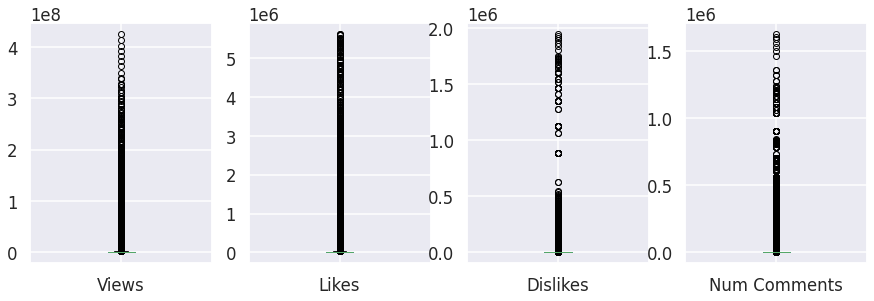

In [65]:
cont_features = ["Views", "Likes", "Dislikes",  "Num Comments"]
# univariate analysis for continuous features to visualize the distributions of the variables  
Countries_df[cont_features].plot(kind='box', figsize=(15, 15), subplots=True, layout=(3, 4))
plt.show()

In [66]:
# correlations between the main continuous varibles
Countries_corrs = Countries_df.corr()
Countries_corrs

,Category ID,Views,Likes,Dislikes,Num Comments,Comments Disabled,Ratings Disabled,Error
Category ID,1.000000,-0.143059,-0.159953,-0.035984,-0.074403,0.027318,0.017496,-0.028717
Views,-0.143059,1.000000,0.779267,0.422929,0.510539,-0.007789,-0.011678,0.007373
Likes,-0.159953,0.779267,1.000000,0.454953,0.793614,-0.029067,-0.032661,0.006543
Dislikes,-0.035984,0.422929,0.454953,1.000000,0.709498,-0.007894,-0.012922,0.005388
Num Comments,-0.074403,0.510539,0.793614,0.709498,1.000000,-0.025675,-0.021702,0.002919
Comments Disabled,0.027318,-0.007789,-0.029067,-0.007894,-0.025675,1.000000,0.317653,-0.004047
Ratings Disabled,0.017496,-0.011678,-0.032661,-0.012922,-0.021702,0.317653,1.000000,-0.003728
Error,-0.028717,0.007373,0.006543,0.005388,0.002919,-0.004047,-0.003728,1.000000


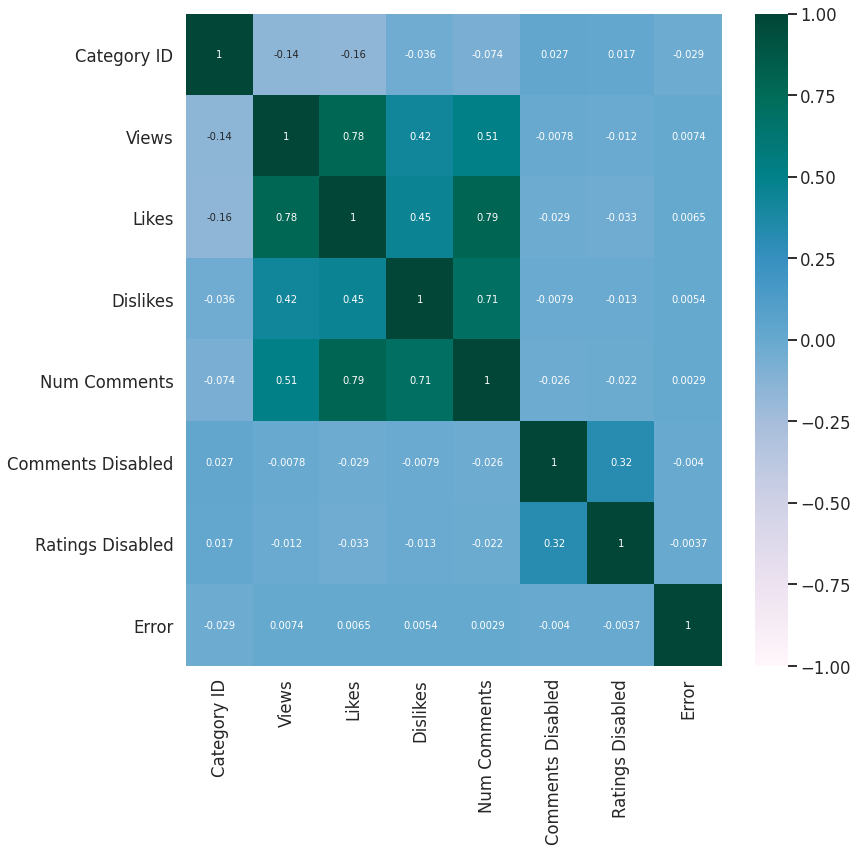

In [67]:
# visualize correlation matrix in a heatmap to easily depict the highly correlated variables
plt.figure(figsize=(12, 12))
sns.heatmap(Countries_corrs, annot=True, vmin=-1.0, cmap='PuBuGn')
plt.show()

Based on the heatmap of the correlation matrix, it is evident that there is again a strong correlation of 0.79 between the number of likes and number of comments as both are correlated in terms of if people like a certain video, they are more likely to comment their reaction as well. Similarly, there is also a strong correlation of 0.78 between the number of likes and number of views, which intuitively makes sense as more liked videos will have more views. The next strongest correlation of 0.71 is between the number of dislikes and the number of comments, as people regardless of their like or dislike towards the video will express their opinions in the comments, so if they are not a fan of the video they will still most likely comment. There is a weaker correlation between the number of dislikes and the number of views, understandably as a more disliked and unpleasant video won't have as many views as one that is more pleasing to viewers.